In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os
import sys
import logging

In [2]:
adata_rbpj_file = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Rbpj_v1.h5ad"
adata_all_ntc = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/adata_ntc.h5ad"
stream_obj_rbpj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_ntc/rbpj_ntc_v2.pkl"
stream_obj_all = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/all_ntc/all_ntc.pkl"
out_dir = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs"

In [3]:
from os.path import basename
import stream as st
adata = st.read(file_name=stream_obj_rbpj, workdir=out_dir)

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Working directory is already specified as '/tmp/tmppovq9_qj' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


### Inspect traj

In [9]:
adata

AnnData object with n_obs × n_vars = 2088 × 1849
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt', 'cell_cluster_colors', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S1_pseudotime'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_counts', 'n_cells', 'pct_cells'
    uns: 'cell_cluster_colors', 'condition_colors', 'orig.ident_colors', 'workdir', 'assay', 'var_genes', 'trans_se', 'params', 'epg', 'flat_tree', 'seed_epg', 'seed_flat_tree', 'ori_epg', 'epg_obj', 'ori_epg_obj', 'branch_id_alias_color'
    obsm: 'X_pca', 'X_umap', 'var_genes', 'X_se', 'X_dr'
    varm: 'PCs'

In [17]:
raw_counts = adata.raw.X.toarray()
display(np.max(raw_counts))
display(np.min(raw_counts))
display(raw_counts.shape)
display(adata.X.shape)
display(np.min(adata.X))
display(np.max(adata.X))

944.0

0.0

(2088, 16368)

(2088, 1849)

-4.2463274

24.211573

In [20]:
# Step 1: Extract raw counts matrix
raw_counts = adata.raw.X.toarray()  # Convert sparse to dense

# Step 2: Get gene names and cell barcodes from raw
gene_names = adata.raw.var_names  # Gene names
cell_barcodes = adata.raw.obs_names  # Cell barcodes (same as adata.obs_names)

# Step 3: Create DataFrame with genes as rows, cells as columns
df_raw = pd.DataFrame(
    raw_counts.T,  # Transpose: genes as rows, cells as columns
    index=gene_names,
    columns=cell_barcodes
)

# Step 4: Verify the data matches what you see
print(f"Matrix shape: {df_raw.shape}")
print(f"Genes (rows): {df_raw.shape[0]}")
print(f"Cells (columns): {df_raw.shape[1]}")
print(f"Min value: {df_raw.min().min()}")
print(f"Max value: {df_raw.max().max()}")

# Check first few genes/cells
print("\nFirst 5 genes x 5 cells:")
print(df_raw.iloc[:5, :5])

# Step 5: Export to TSV
df_raw.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/data/raw_counts_gene_by_cell.tsv', sep='\t')

print("\n✓ Exported to: raw_counts_gene_by_cell.tsv")

Matrix shape: (16368, 2088)
Genes (rows): 16368
Cells (columns): 2088
Min value: 0.0
Max value: 944.0

First 5 genes x 5 cells:
         S4_AAACCCAAGCACGATG-1  S4_AAACCCAGTGAATAAC-1  S4_AAACCCAGTGGAGGTT-1  \
Mrpl15                     3.0                   11.0                    2.0   
Lypla1                     0.0                    1.0                    0.0   
Gm37988                    0.0                    0.0                    0.0   
Tcea1                      1.0                    0.0                    1.0   
Atp6v1h                    1.0                    1.0                    0.0   

         S4_AAACGAAGTGAGGAAA-1  S4_AAACGAAGTGTAACGG-1  
Mrpl15                    17.0                    2.0  
Lypla1                     4.0                    0.0  
Gm37988                    0.0                    0.0  
Tcea1                      5.0                    0.0  
Atp6v1h                    0.0                    0.0  

✓ Exported to: raw_counts_gene_by_cell.tsv


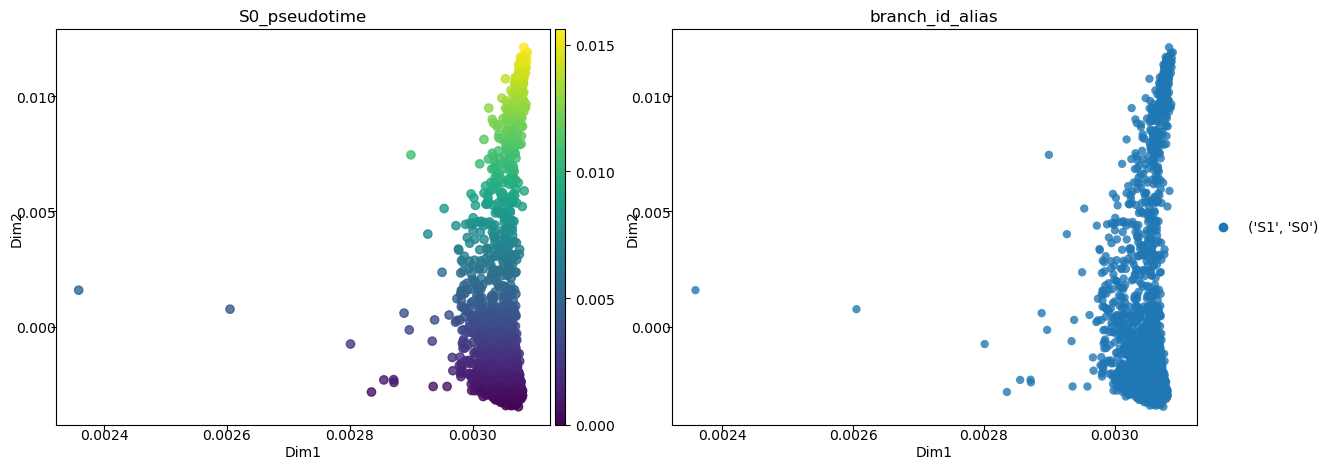

In [5]:
st.plot_dimension_reduction(adata,color=['S0_pseudotime','branch_id_alias'])

In [7]:
# get max of S0_pseudotime
max_S0_pseudotime = adata.obs['S0_pseudotime'].max()
display(max_S0_pseudotime)
# get min of S0_pseudotime
min_S0_pseudotime = adata.obs['S0_pseudotime'].min()
display(min_S0_pseudotime)

0.01559948871363576

0.0

## Pre-processing for stream

In [30]:
st.cal_qc(adata,assay='rna')

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:427: RuntimeWarning: divide by zero encountered in true_divide
  adata.obs['pct_mt'] = n_counts_mt/n_counts


In [32]:
st.filter_cells(adata,min_n_features= 100)
st.filter_features(adata,min_n_cells = 5)

filter cells based on min_n_features
after filtering out low-quality cells: 
4772 cells, 2000 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
4772 cells, 1854 genes


In [33]:
###Normalize gene expression based on library size  
st.normalize(adata,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata)
###Remove mitochondrial genes 
st.remove_mt_genes(adata)

remove mitochondrial genes:
['mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd6', 'mt-Cytb']


/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:748: RuntimeWarning: invalid value encountered in log2
  adata.X = np.log2(adata.X+1)/np.log2(base)


In [34]:
import numpy as np
import scipy.sparse as sp

X = adata.X
if sp.issparse(X):
    data = X.data
    data[np.isnan(data)] = 0
    X.eliminate_zeros()
else:
    np.nan_to_num(X, copy=False)  # in-place: NaN->0, inf->large finite

In [35]:
n_nans = np.isnan(X.data).sum() if sp.issparse(X) else np.isnan(X).sum()
display(n_nans)
display(adata.X.size)

0

8823428

# Run stream dim reduction

370 variable genes are selected


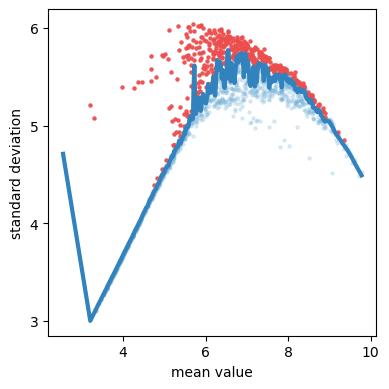

In [36]:
# # Setting var_genes if you need to select top 3k genes from a list of more than 3k genes
#adata_imputed.X = adata_imputed.layers['MAGIC_imputed_data']
st.select_variable_genes(adata,loess_frac=0.01,percentile=80)

In [37]:
# # 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
# # n_components = Number of branches present in your biological differentation
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature var_genes is being used ...
64 cpus are being used ...


In [38]:
# # Order the cell states for plotting (colors need to be categorical)
adata.obs['cell_cluster'] = pd.Categorical(
    adata.obs['cell_cluster'],
    categories=['Tpex', 'Tex'],
    ordered=True
)
colormap = {'Tpex': 'darkblue', 'Tex': 'lightpink'}
# Create a new column in adata.obs for colors
adata.obs['cell_cluster_colors'] = adata.obs['cell_cluster'].map(colormap)

In [39]:
adata_Tpex = adata[adata.obs['cell_cluster'] == 'Tpex']
adata_Tex = adata[adata.obs['cell_cluster'] == 'Tex']

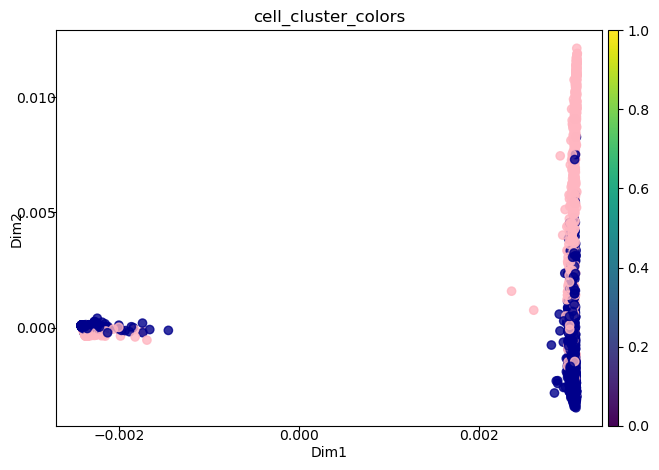

In [40]:
st.plot_dimension_reduction(adata, color=['cell_cluster_colors'], n_components=2)

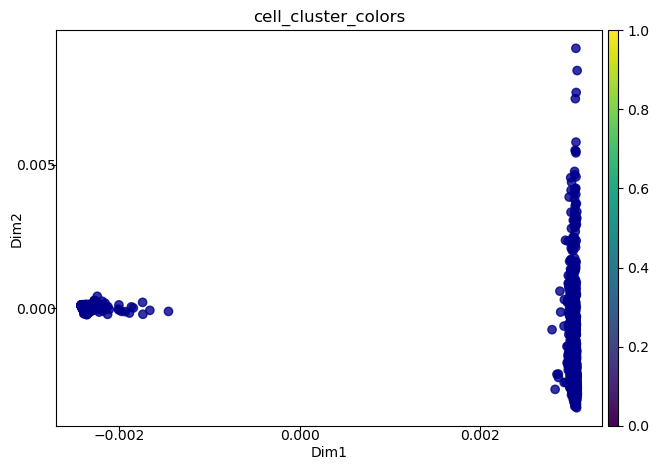

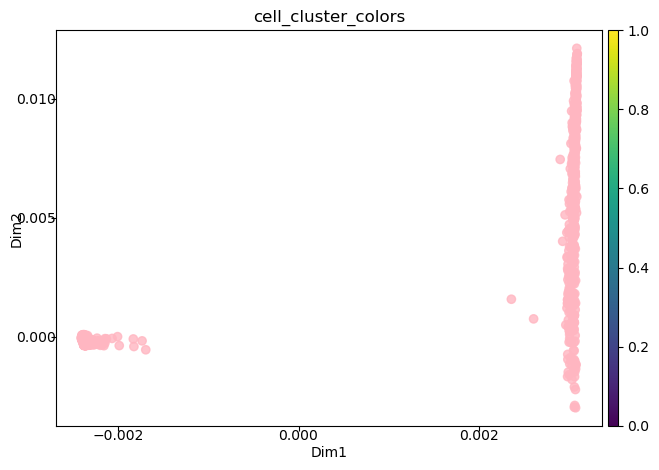

In [41]:
st.plot_dimension_reduction(adata_Tpex, color=['cell_cluster_colors'], n_components=2)
st.plot_dimension_reduction(adata_Tex, color=['cell_cluster_colors'], n_components=2)

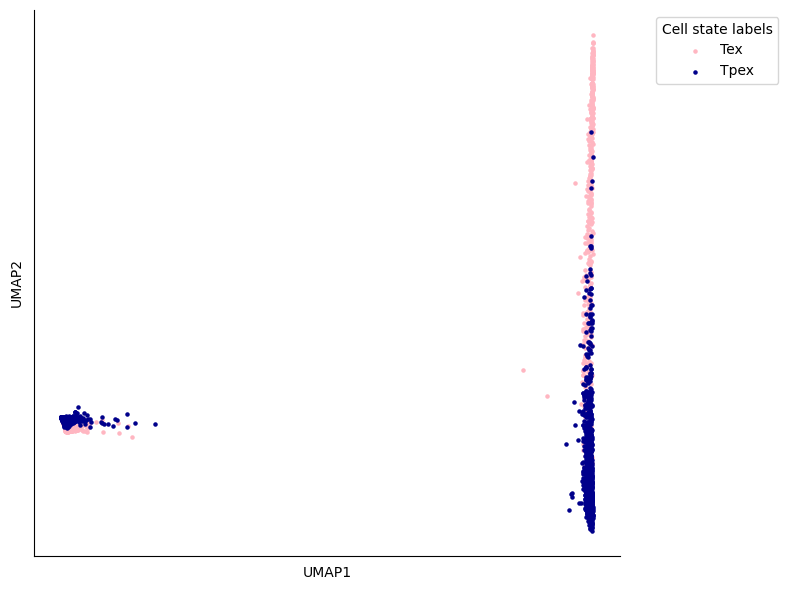

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr'/'X_mlle' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['cell_cluster']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [colormap[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip (unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Cell state labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/bifurcation_male.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')        # Specify PDF format
plt.show()

## Infer the traj by fitting elastic graph

In [43]:
import os
os.environ.pop('R_LIBS_USER', None)  # Remove custom library path
os.environ.pop('R_LIBS', None)

'/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/R/library'

In [44]:
from rpy2.robjects import r
r('library(rlang)')

'rlang','tools','stats','graphics',...,'utils','datasets','methods','base'


In [45]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

Saving results in: /tmp/tmp41rq6zd6
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 4772 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
1.749e-07
	
50
	
49
	
46
	
1
	
0
	
0
	
2.234e-08
	
1.839e-08
	
0.9985
	
0.9987
	
1.441e-07
	
8.467e-09
	
4.233e-07
	
2.117e-05
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


23.486 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


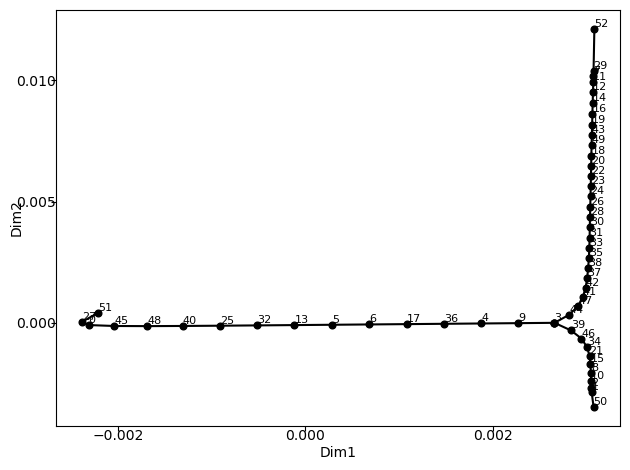

In [46]:
st.plot_branches(adata,show_text=True, n_components=2)

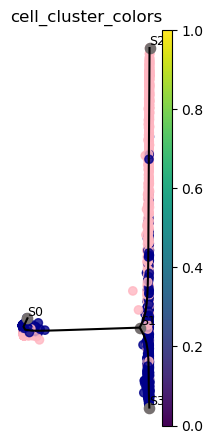

In [47]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['cell_cluster_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


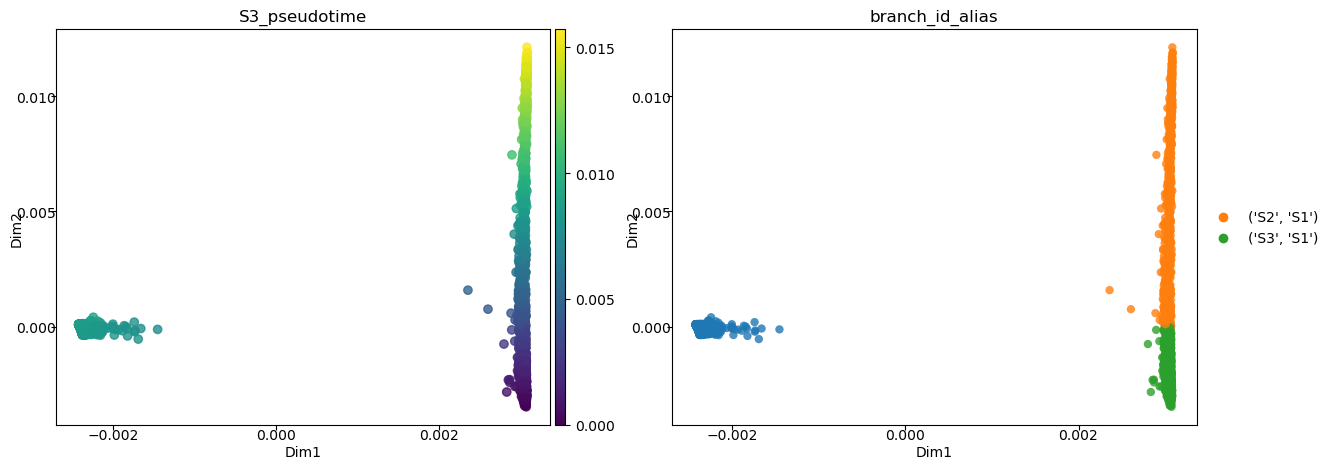

In [48]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S3_pseudotime','branch_id_alias'])

# Subset to correct path and refit traj

In [49]:
# subset adata to exclude cells on branch S0,S1
adata.obs['branch_id_alias'].value_counts()

(S0, S1)    2684
(S3, S1)    1486
(S2, S1)     602
Name: branch_id_alias, dtype: int64

In [50]:
adata = adata[adata.obs['branch_id_alias'] != ('S0','S1')]

In [72]:
adata_Tpex = adata[adata.obs['cell_cluster'] == 'Tpex']
adata_Tex = adata[adata.obs['cell_cluster'] == 'Tex']

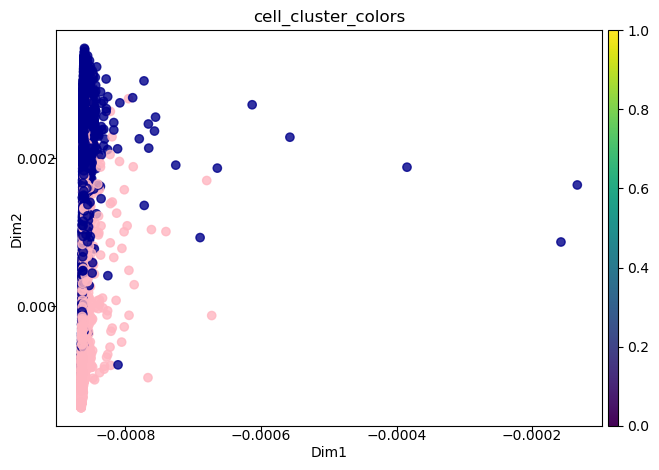

In [71]:
st.plot_dimension_reduction(adata, color=['cell_cluster_colors'], n_components=2)

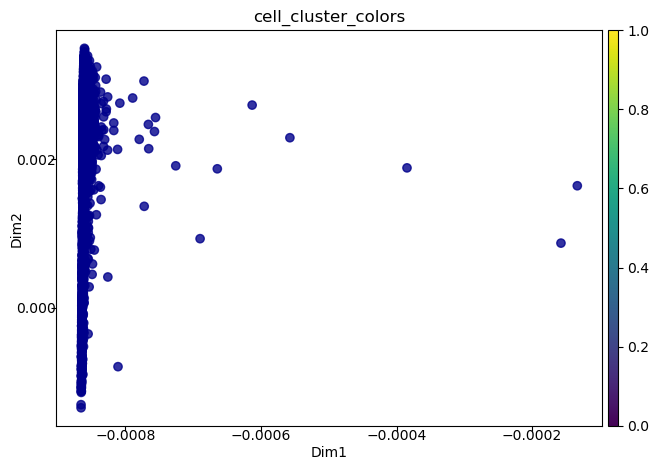

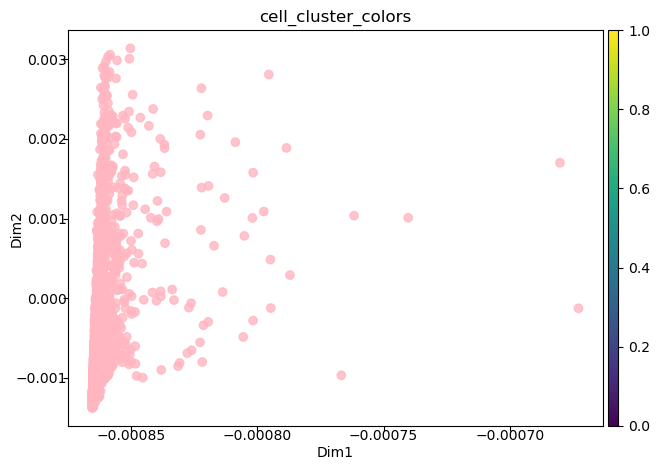

In [73]:
st.plot_dimension_reduction(adata_Tpex, color=['cell_cluster_colors'], n_components=2)
st.plot_dimension_reduction(adata_Tex, color=['cell_cluster_colors'], n_components=2)

In [54]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


Saving results in: /tmp/tmppovq9_qj
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 1
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 2088 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50
	
9.796e-08
	
50
	
49
	
48
	
0
	
0
	
0
	
1.312e-08
	
8.006e-09
	
0.9992
	
0.9995
	
8.183e-08
	
3.005e-09
	
1.502e-07
	
7.512e-06
	
0


9.188 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 1
Extending leaves with additional nodes ...
Number of branches aft

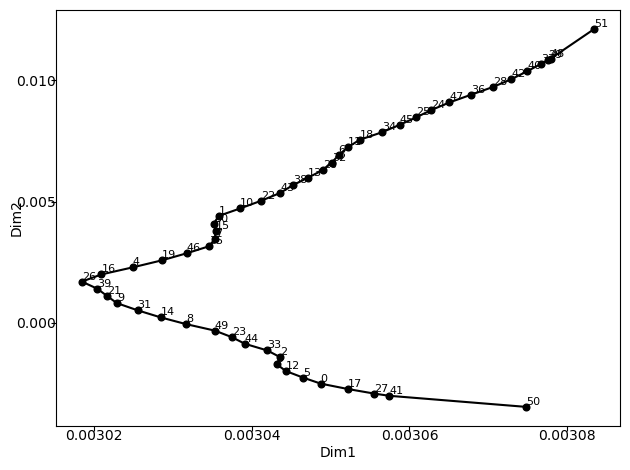

In [55]:
st.plot_branches(adata,show_text=True, n_components=2)

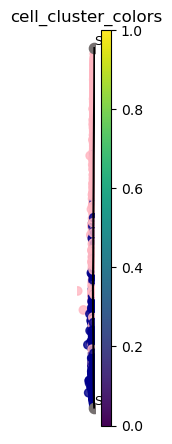

In [56]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['cell_cluster_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In [4]:
adata.obs['branch_id_alias'].value_counts()

(S1, S0)    14196
Name: branch_id_alias, dtype: int64

In [59]:
adata.obs['orig.ident'].value_counts()

S4_sgNTC    2088
Name: orig.ident, dtype: int64

In [60]:
# write adata_rbpj_ntc to a file
st.write(adata, file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_ntc_v2.pkl')

## Dictys inputs

In [74]:
adata.obs['condition'].value_counts()


NTC    14196
Name: condition, dtype: int64

In [76]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files

# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
#display(branch)
branch.to_csv(os.path.join(out_dir,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
display(edge)
edge=pd.DataFrame(edge)
edge.to_csv(os.path.join(out_dir,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv(os.path.join(out_dir,'dist.tsv.gz'),header=True,index=True,sep='\t')

array([[0, 1]])

In [77]:
dictys_data_path = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ets1_ikzf1_ntc/data"
# cell type subsets
adata.obs.cell_cluster.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')

In [6]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2088 × 0
    obs: 0
    obsm: 'X_dr'

In [7]:
# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

                     NaN         x         y
0  S4_AAACCCAAGCACGATG-1  0.003076  0.010509
1  S4_AAACCCAGTGAATAAC-1  0.003060 -0.002830
2  S4_AAACCCAGTGGAGGTT-1  0.003062 -0.002226
3  S4_AAACGAAGTGAGGAAA-1  0.003065 -0.002647
4  S4_AAACGAAGTGTAACGG-1  0.003047 -0.002123


In [80]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])